# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import warnings
from scipy.stats import chi2_contingency,ttest_ind,kendalltau
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Descripcion del dataset

- Pregnancy : numero de veces embarazada \
- Glucose : Concentración plasmática de glucosa a las 2 horas en una prueba oral de tolerancia a la glucosa\
- BloodPressure : Presión arterial diastólica (mm Hg)\
- SkinThickness : Grosor del pliegue cutáneo del tríceps (mm)\
- Insulin : Insulina sérica a las 2 horas (mu U/ml)\
- BMI : Índice de masa corporal (peso en kg/(altura en m)^2)\
- DiabetesPedigreeFunction : Función pedigrí de la diabetes\
- Age : Edad (años)\
- Outcome :1 si la persona tiene diabete sino 0 (268 de 768 son 1, las demás son 0)

# Hipotesis a probar

- H1 : cuanto mas una persona es vieja cuanto mas probabilidad tiene diabete\
- H2 : cuanto mas una persona tiene insulin cuanto mas probabilidad tiene diabete

# Lectura de los datos

In [27]:
#df_raw = pd.read_csv(r'..\data\IN\diabetes.csv')
df_raw = pd.read_csv(r'../data/IN/diabetes.csv')

In [28]:
df_init=df_raw.copy()

In [29]:
df_raw.shape

(768, 9)

In [30]:
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [31]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [32]:
df_raw.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [33]:
df_raw["Outcome"]=df_raw["Outcome"].astype("object")

In [34]:
cat_cols = ["Outcome"]
num_cols = [col for col in df_raw.columns if df_raw[col].dtype in ['int64', 'float64']]

In [35]:
df_raw.duplicated().sum()

np.int64(0)

# Análisis univariante

In [36]:
for col in df_raw.columns:
    value_counts = df_raw[col].value_counts().head(10)
    percentage = round(value_counts/df_raw.shape[0] * 100,2)
    print("\033[1m\033[4m" + col + "\033[0m")
    print(pd.DataFrame({'Valor': value_counts.index, 'Nombre': value_counts.values, 'Porcentaje': percentage.values}))
    print(f"Type {df_raw[col].dtype}")
    print("-----------------------------")

Pregnancies
   Valeur  Nombre  Pourcentage
0       1     135        17.58
1       0     111        14.45
2       2     103        13.41
3       3      75         9.77
4       4      68         8.85
5       5      57         7.42
6       6      50         6.51
7       7      45         5.86
8       8      38         4.95
9       9      28         3.65
Type int64
-----------------------------
Glucose
   Valeur  Nombre  Pourcentage
0      99      17         2.21
1     100      17         2.21
2     111      14         1.82
3     129      14         1.82
4     125      14         1.82
5     106      14         1.82
6     112      13         1.69
7     108      13         1.69
8      95      13         1.69
9     105      13         1.69
Type int64
-----------------------------
BloodPressure
   Valeur  Nombre  Pourcentage
0      70      57         7.42
1      74      52         6.77
2      78      45         5.86
3      68      45         5.86
4      72      44         5.73
5      64      4

La variable Outcome que indica si una persona tiene diabete o no esta muy desbalanceada (solo 34.9% de si). Quasi la mitad de la gente que no tiene Insulina (48.7%). Casi 50% de la poblecion tiene menos de 3 ninos. 

## Cuantitativa

In [37]:
df_raw.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T.sort_values(by='50%', ascending=False).style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,167.000000,181.000000,196.000000,199.000000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,88.000000,90.000000,106.000000,122.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,41.500000,44.395000,50.759000,67.100000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,210.000000,293.000000,519.900000,846.000000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,51.000000,58.000000,67.000000,81.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,40.000000,44.000000,51.330000,99.000000
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,9.000000,10.000000,13.000000,17.000000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,0.878600,1.132850,1.698330,2.420000


Aqui podemos tomar decisiones sobre como los tratariamos, en el caso de Insulina, vamos a considerar por encima de 500 como outlier, aunque hemos revisado datos medicos como es una clasificacion que podria tener riesgo vamos a poner ese limite superior. En diversos recursos encontramos que en condiciones muy específicas como insulinomas (tumores productores de insulina) o ciertos síndromes genéticos, los niveles pueden dispararse. El limite superior lo vamos a imputar con la mediana, al igual que en la columna de SkinThickness.

El resto de valores aplicaremos la windsorizacion con el rango intercuartílico. 

No es possible tener un BMI a 0. Misma cosa por la presión arterial diastólica y el grosor del pliegue cutáneo del tríceps.\
Los indices de masa corporal son muy altos pero esto puede ser porque india es un pays con mucha obesidad y nuestro dataset tiene gente con sobrepeso por quasi todos.\
Imputaremos con datos del dataset (mediana, IQR y windsorizacion) para no perder informaciones pero como representan mucha gente quizas no esteramos tan cerca de la realidad.\
Se puede considerar una imputacion KNN o iterativa.

In [38]:
df_raw[num_cols].skew().sort_values(ascending=False)

Insulin                     2.272251
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Pregnancies                 0.901674
Glucose                     0.173754
SkinThickness               0.109372
BMI                        -0.428982
BloodPressure              -1.843608
dtype: float64

In [39]:
df_raw[num_cols].kurt().sort_values(ascending=False)

Insulin                     7.214260
DiabetesPedigreeFunction    5.594954
BloodPressure               5.180157
BMI                         3.290443
Age                         0.643159
Glucose                     0.640780
Pregnancies                 0.159220
SkinThickness              -0.520072
dtype: float64

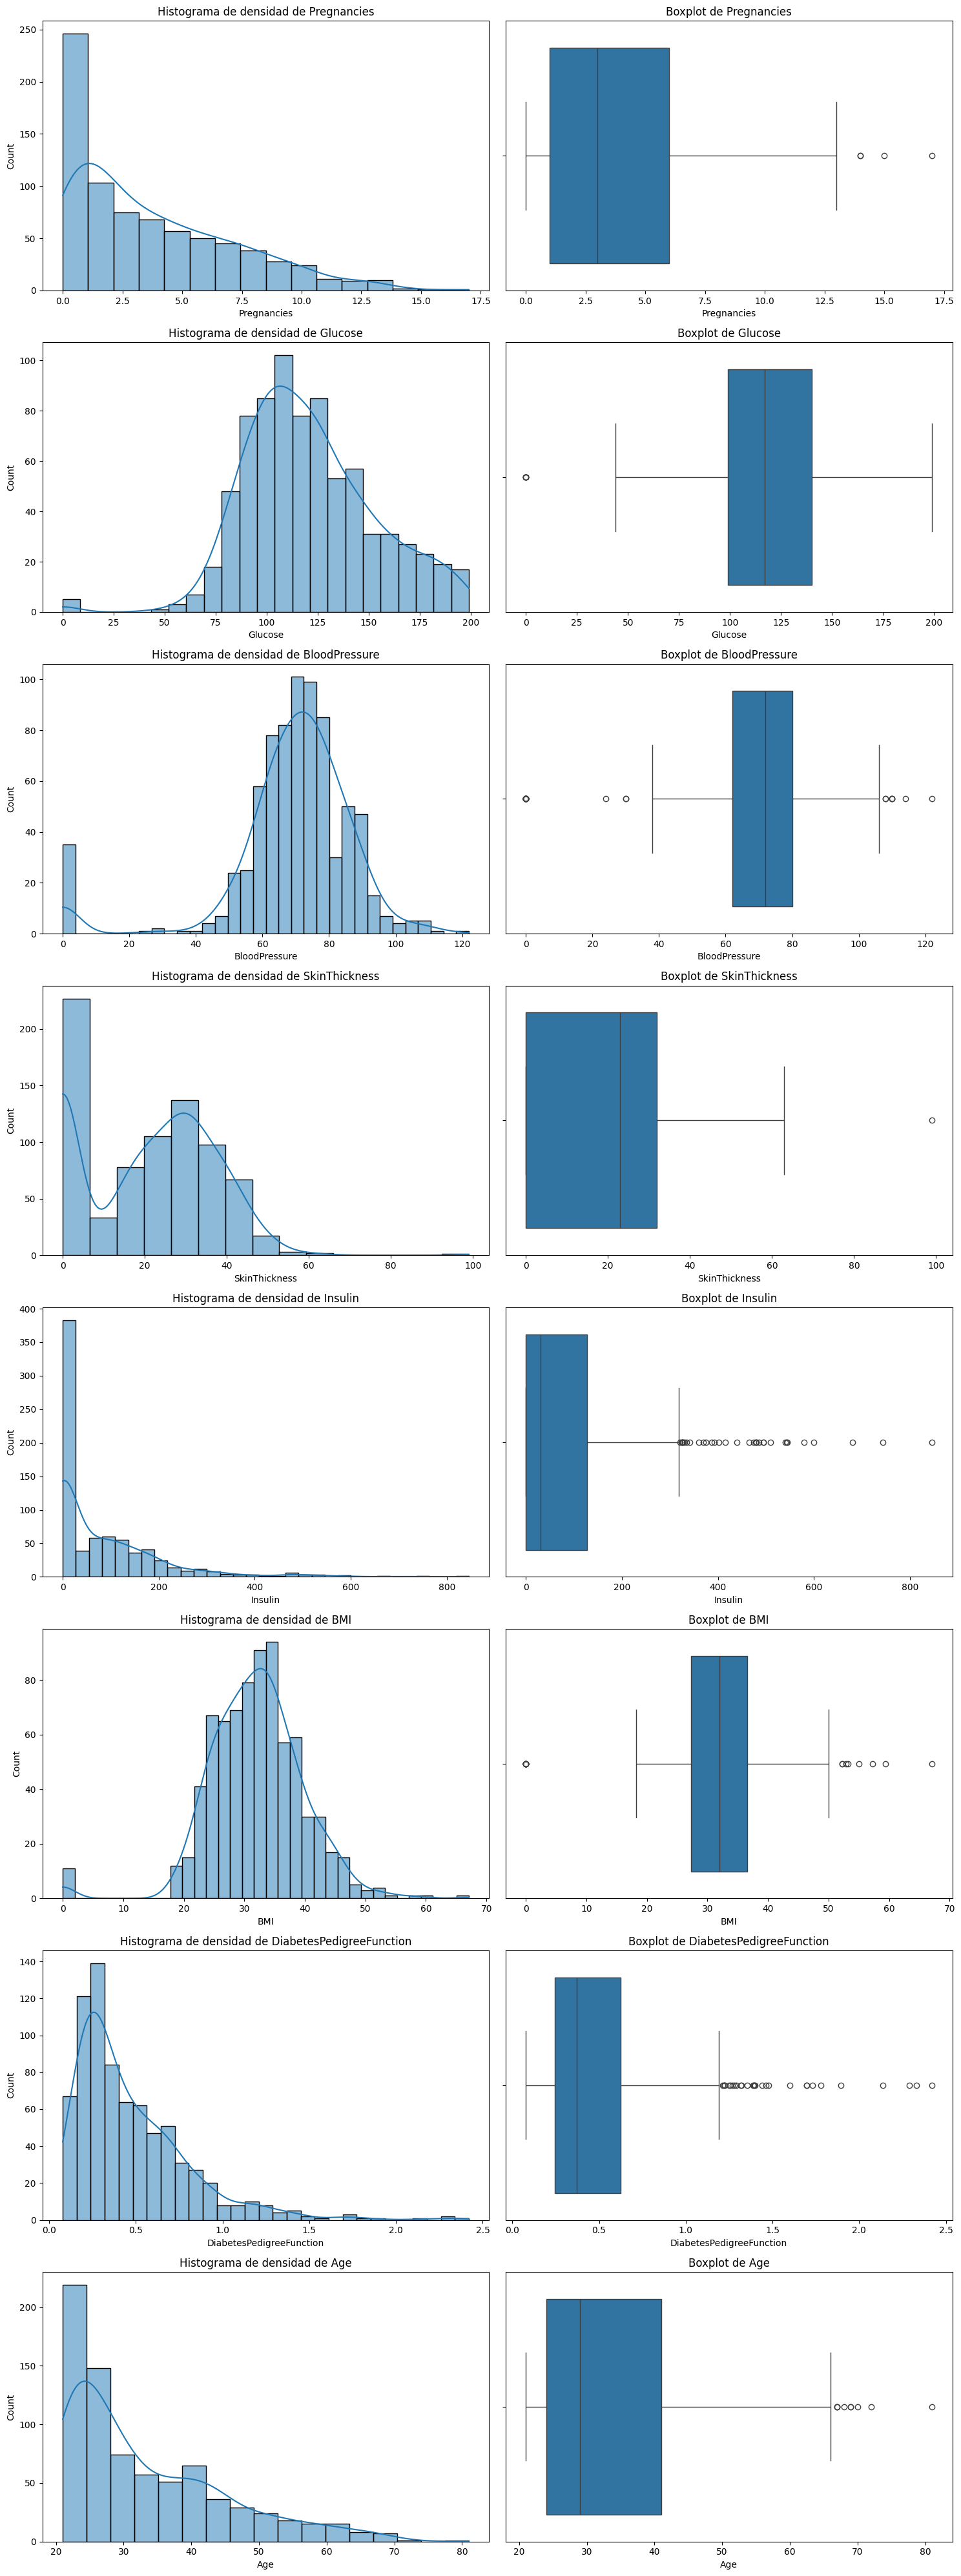

In [40]:
fig, axes = plt.subplots(nrows=len(df_raw.select_dtypes(include=[np.number]).columns), ncols=2, figsize=(15, 5 * len(df_raw.select_dtypes(include=[np.number]).columns)))

for i, column in enumerate(df_raw[num_cols]):
    # Histograma de densidad
    sns.histplot(df_raw[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
    # Boxplot
    sns.boxplot(x=df_raw[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {column}')

plt.tight_layout()
plt.show()

nsulin y SkinThickness tienen muchísimos valores en cero y están muy sesgadas hacia la derecha. Claramente necesitan imputación.

- Se ven varios outliers en Insulin, BMI, Age y DiabetesPedigreeFunction, pero muchos parecen plausibles, así que no conviene eliminarlos a la ligera.
- Glucose y BMI tienen distribuciones bastante normales, lo cual es ideal para modelado.
- Variables como Pregnancies, Age y DiabetesPedigreeFunction están concentradas en valores bajos, lo que tiene sentido considerando el perfil demográfico del dataset.

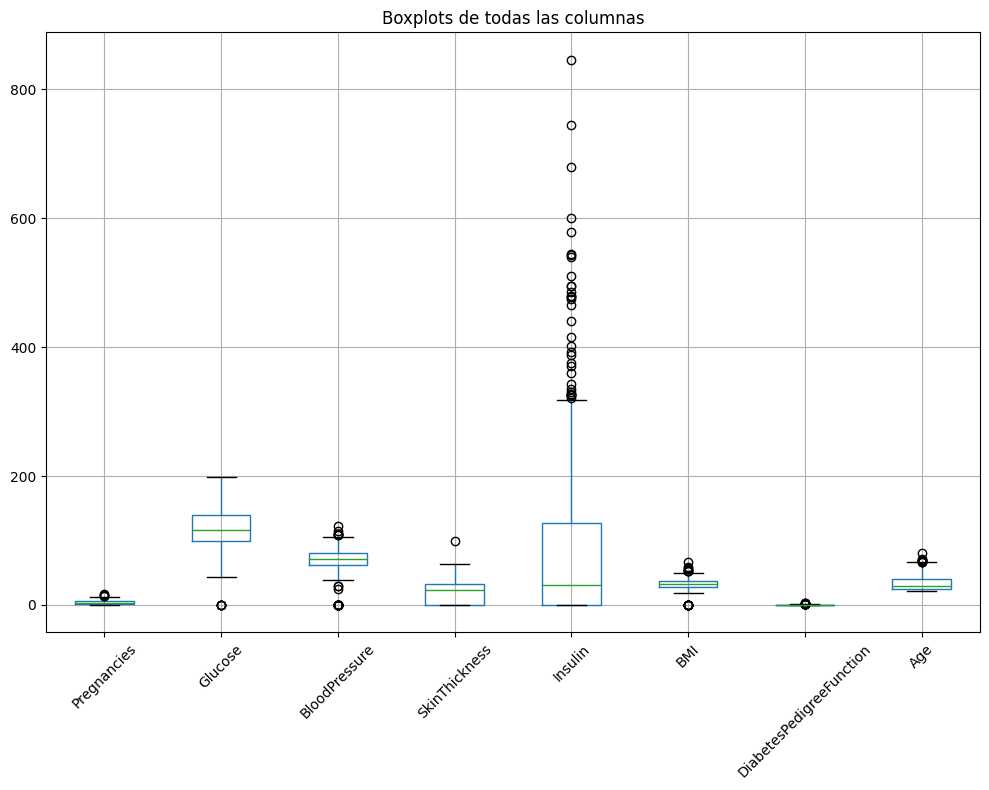

In [41]:
# Genera boxplots para cada columna numérica del DataFrame
df_raw.boxplot(figsize=(10, 8), rot=45)
plt.title('Boxplots de todas las columnas')
plt.tight_layout()  # Para ajustar mejor el espacio de la gráfica
plt.show()

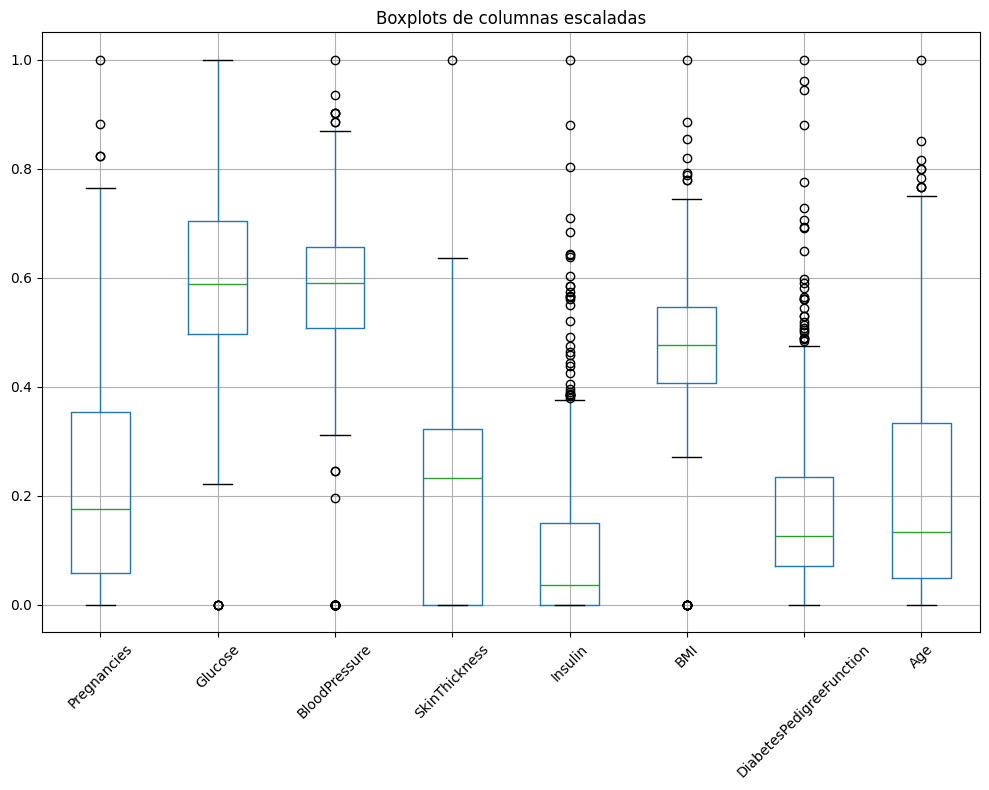

In [42]:
from sklearn.preprocessing import MinMaxScaler

df_numeric = df_raw[num_cols]

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=num_cols)

# Genera boxplots para las columnas escaladas
df_scaled.boxplot(figsize=(10, 8), rot=45)
plt.title('Boxplots de columnas escaladas')
plt.tight_layout()
plt.show()

Se observan muchos outliers, algunos probablemente debidos a valores faltantes mal codificados (como ceros), y otros claramente datos muy atípicos, como en el caso de Pregnancies.

## CUALITATIVA

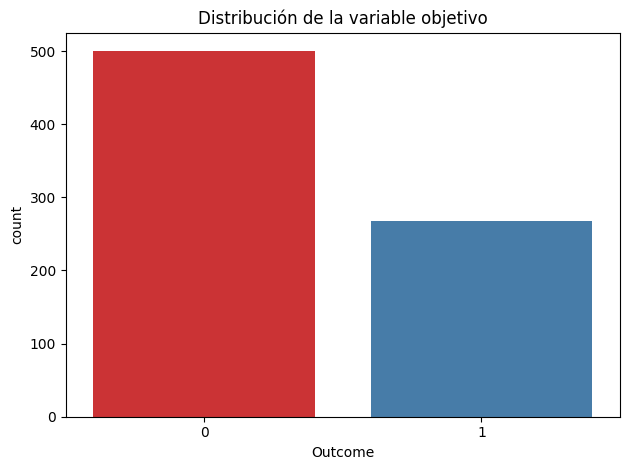

In [64]:
sns.countplot(data=df_raw, x=df_raw["Outcome"], order=df_raw["Outcome"].value_counts().index, palette="Set1")
plt.title("Distribución de la variable objetivo")
plt.tight_layout()
plt.show()

# ANÁLISIS BIVARIANTE

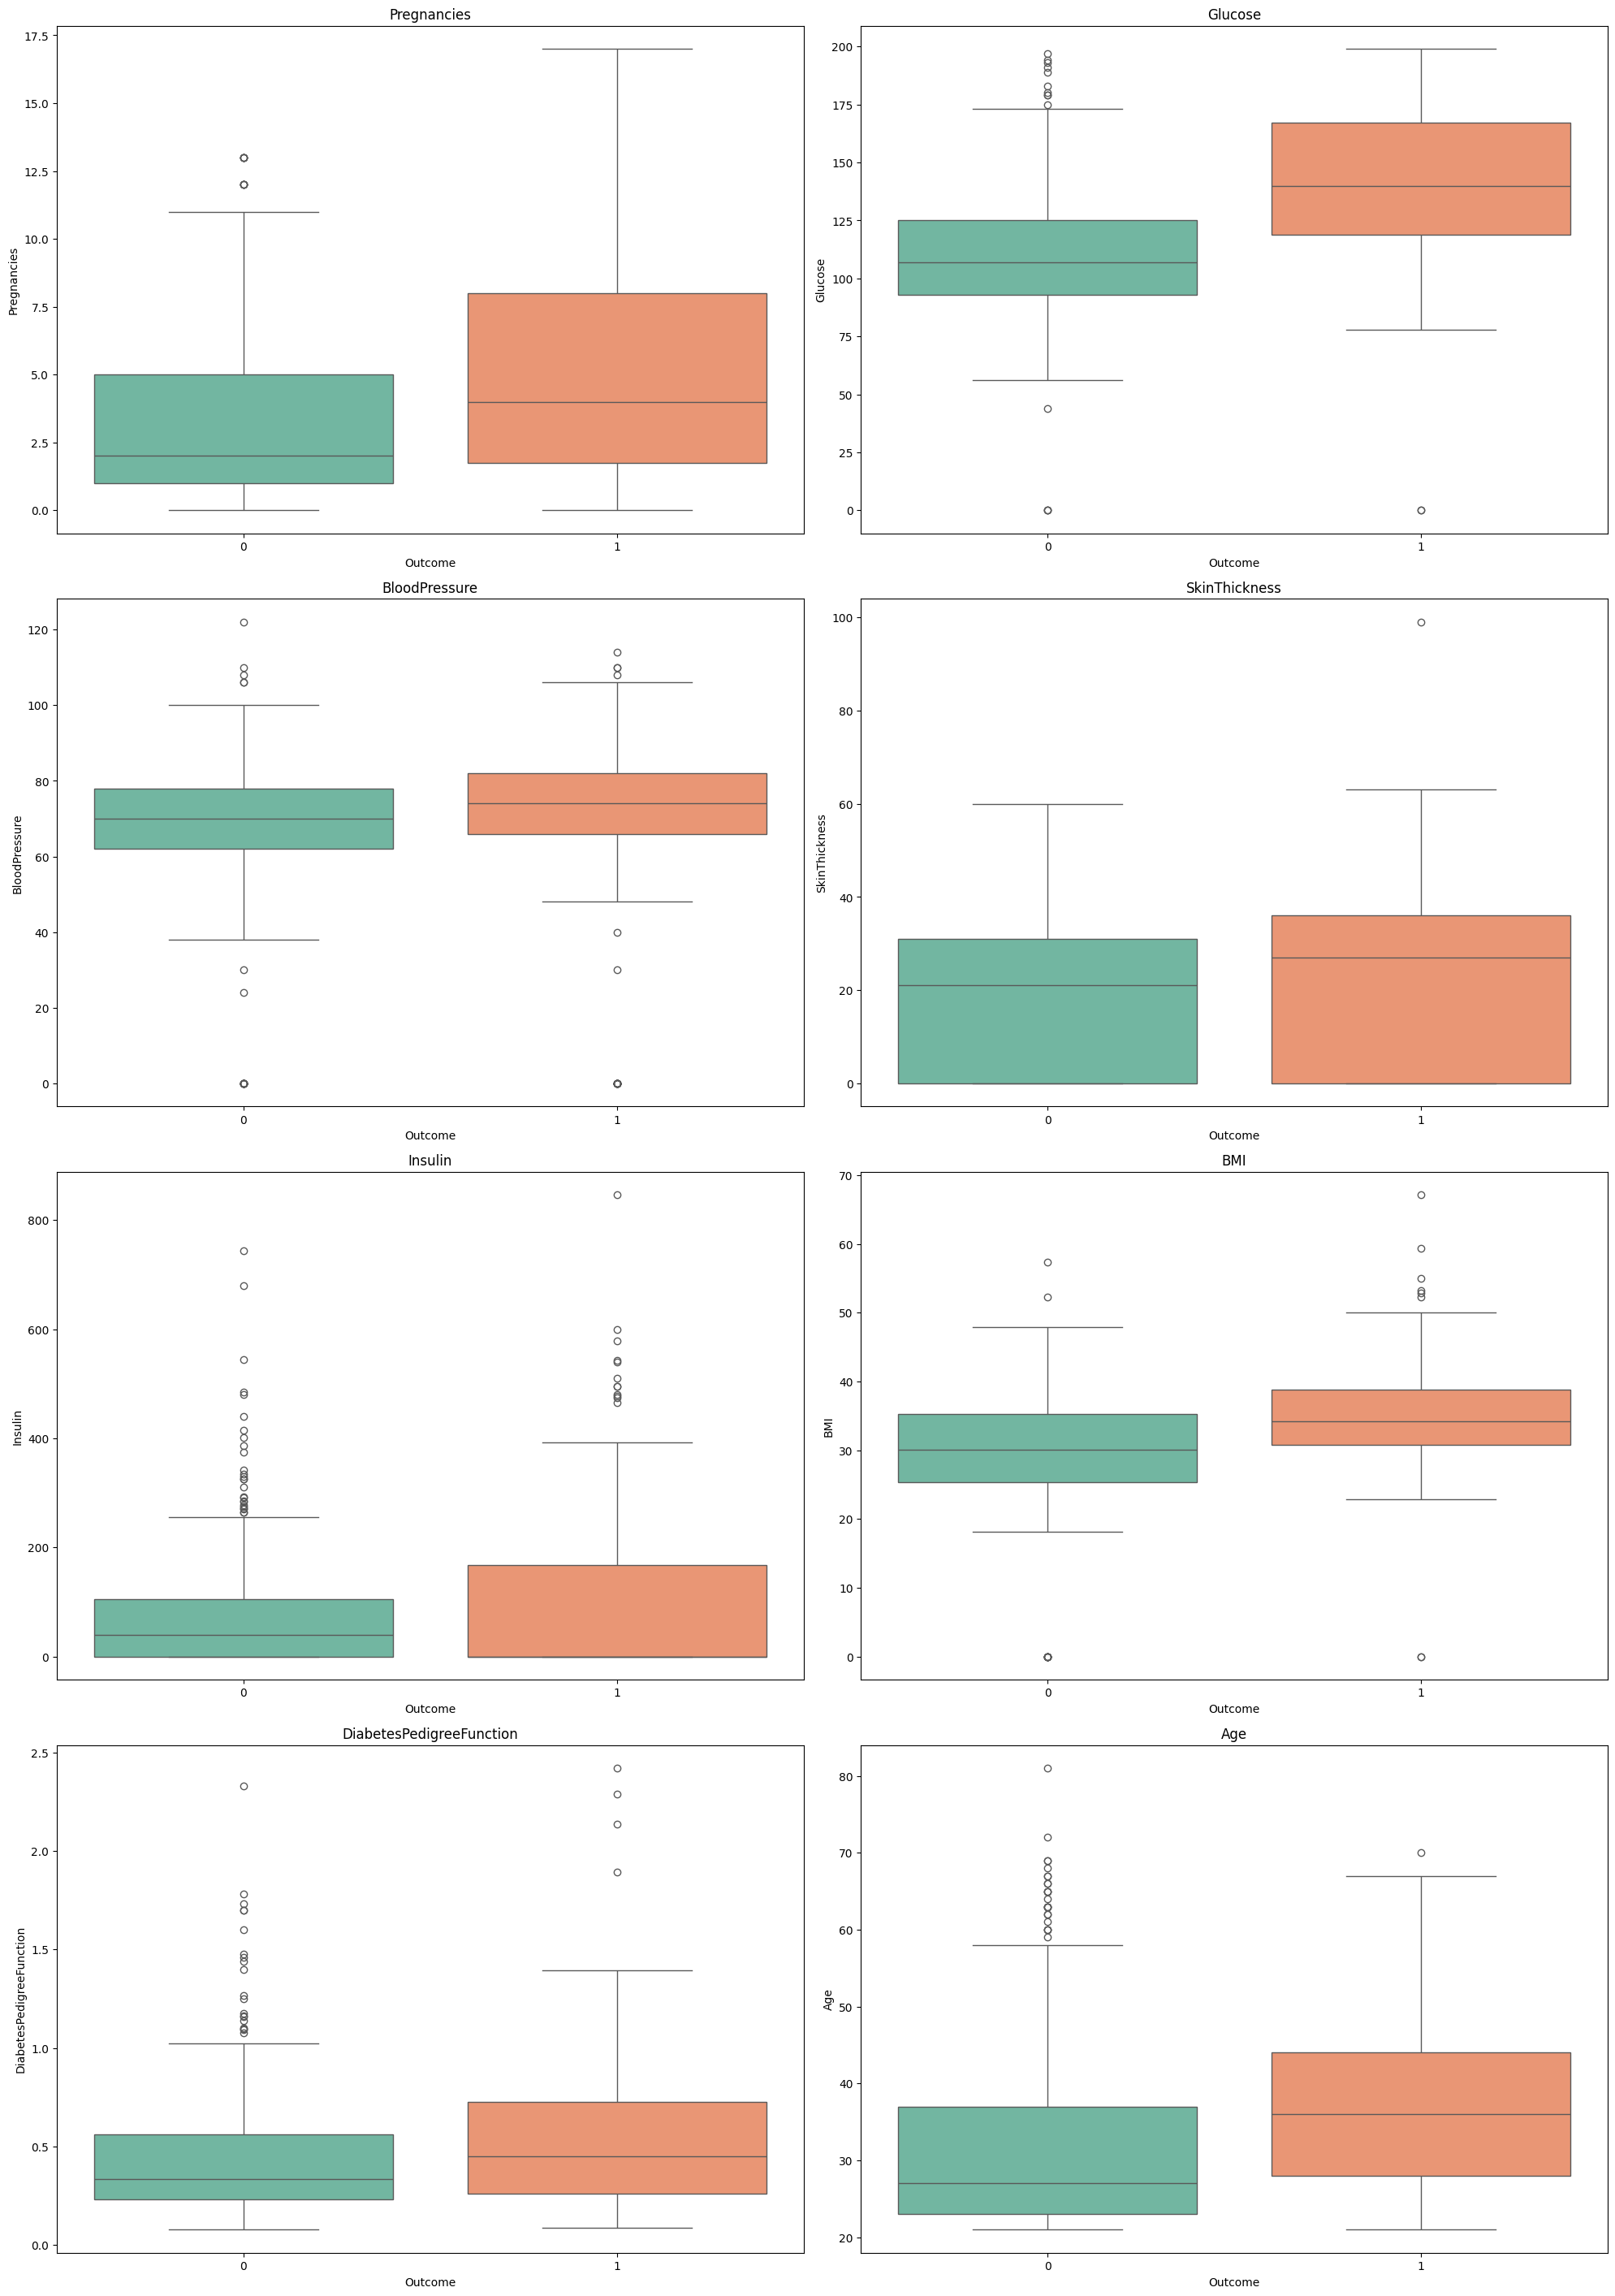

In [44]:
plt.figure(figsize=(20,35))


for i, var in enumerate(num_cols):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data = df_raw, x = 'Outcome', y = var, palette="Set2")
    plt.title(var)


plt.tight_layout()
plt.show()

H1: Las personas con diabetes tienden a tener niveles de glucosa notablemente más altos. En general, los no diabéticos se concentran entre 90 y 125, mientras que los diabéticos suelen estar entre 120 y 170.

H2: En el caso de la insulina, no se observa una diferencia tan marcada entre ambos grupos, aunque los valores parecen ligeramente más altos en personas con diabetes.

# Multivariante

In [45]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

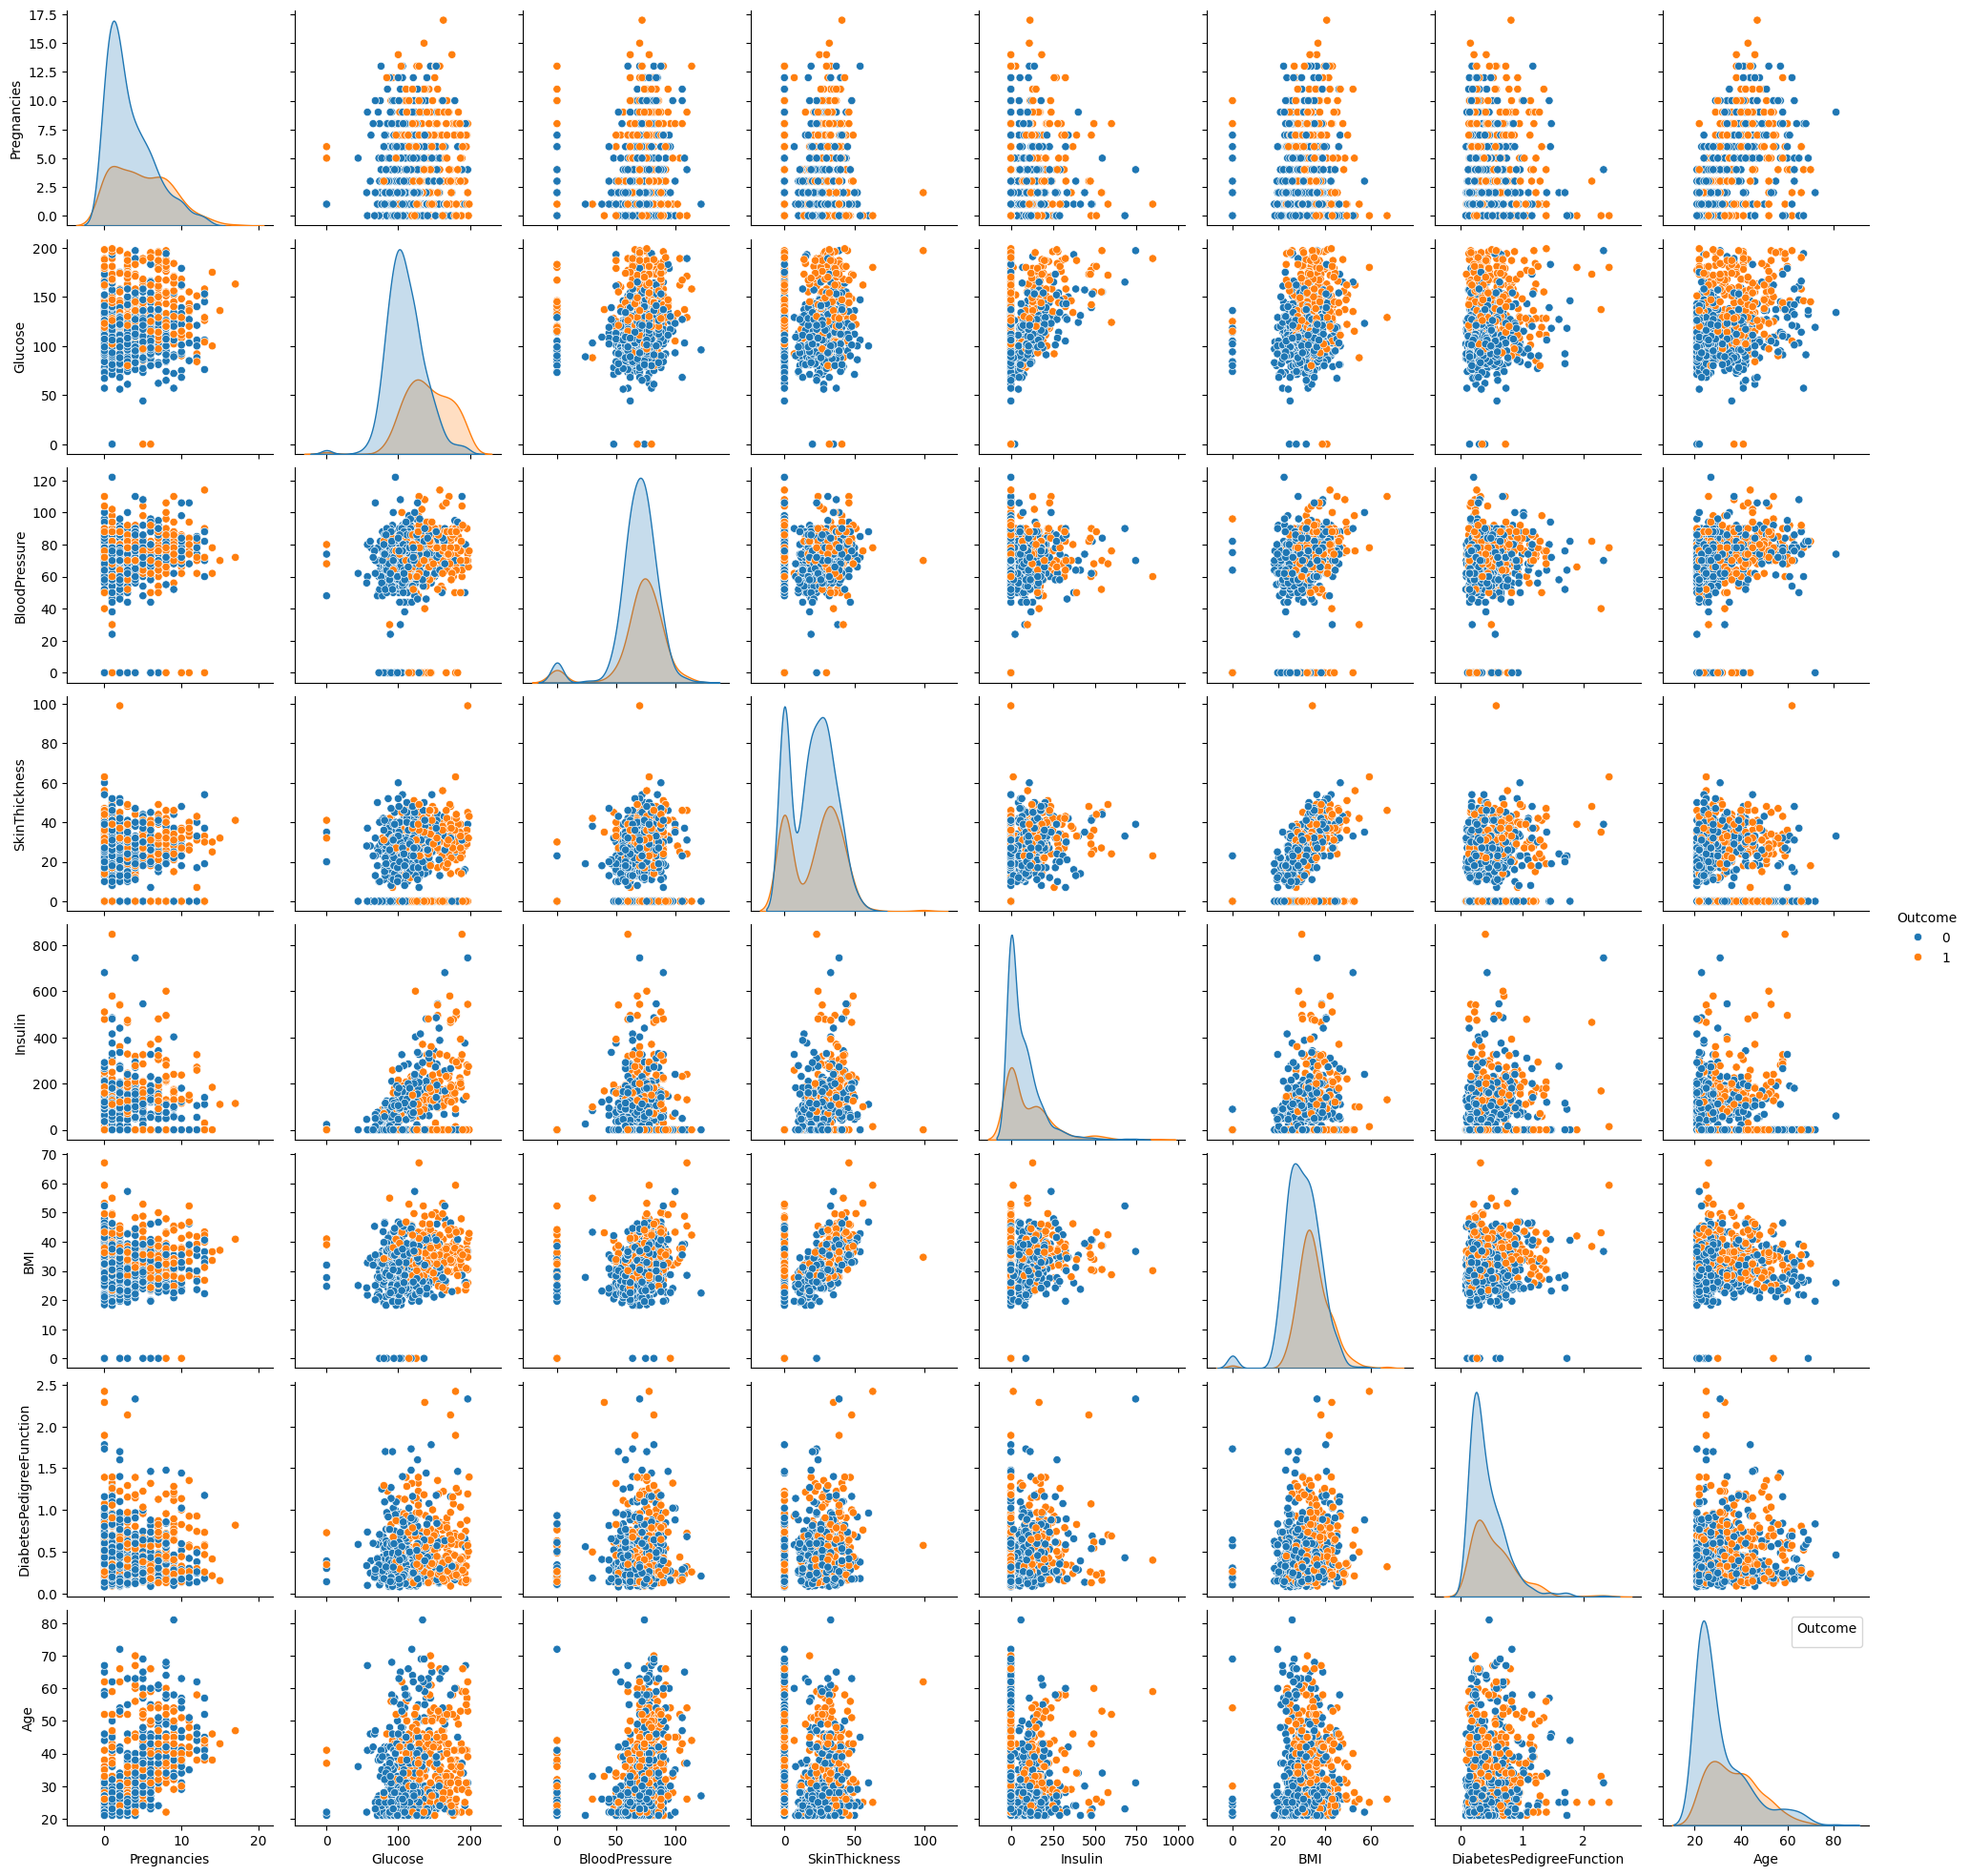

In [46]:
sns.pairplot(df_raw[num_cols + ['Outcome']], diag_kind='kde', hue='Outcome')
plt.legend(title='Outcome')
plt.show()

H3: Se nota una correlación positiva entre Glucose y Insulin, especialmente en personas con diabetes (puntos naranjas). Esto tiene sentido fisiológicamente, ya que altos niveles de glucosa suelen ir acompañados de una mayor producción (o administración) de insulina.

H4: También hay una leve tendencia ascendente entre BMI y SkinThickness, lo cual es esperable ya que ambos están relacionados con el tejido graso corporal.

H5: Las personas con diabetes tienden a tener mayores valores de Pregnancies, BMI, Age y DiabetesPedigreeFunction, aunque las diferencias no son tan claras como con la glucosa.

## Correlaciones

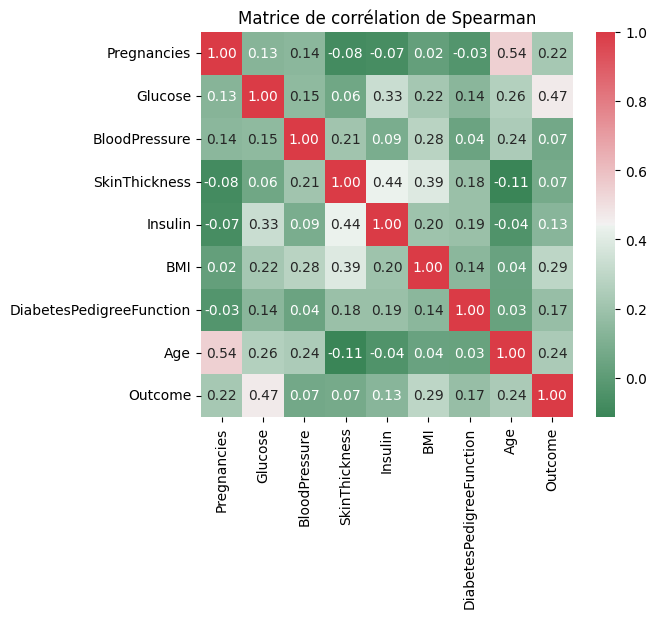

In [ ]:
cmap = sns.diverging_palette(500, 10, as_cmap=True)
plt.figure(figsize=(6, 5))
corr = df_raw[num_cols+["Outcome"]].corr(method='pearson')
sns.heatmap(corr, annot=True, cmap=cmap, fmt=".2f")
plt.title("Matrice de correlación de Spearman")
plt.show()

1.	Mayor correlación con el diagnóstico (Outcome):

-	Glucose (0.47): Es la variable más correlacionada con el resultado de diabetes, lo que confirma su valor como principal predictor.
-	Le siguen BMI (0.29) y Age (0.24), lo cual también tiene sentido clínico.

2.	Correlaciones entre variables:

-   Insulin tiene una correlación alta con SkinThickness (0.44) y Glucose (0.33).
-	SkinThickness y BMI (0.39) también están bien relacionadas.
-   Tenemos una gran correlación entre la edad y el nombre de ninos.

3.	Relaciones débiles o negativas:

-	Algunas variables como Pregnancies o DiabetesPedigreeFunction tienen correlaciones débiles con casi todas las demás, lo que sugiere que aportan información única.

4.	Poca multicolinealidad:

-	No hay correlaciones extremadamente altas entre variables independientes (todas < 0.5), buen indicador de cara al modelo predictivo.
    

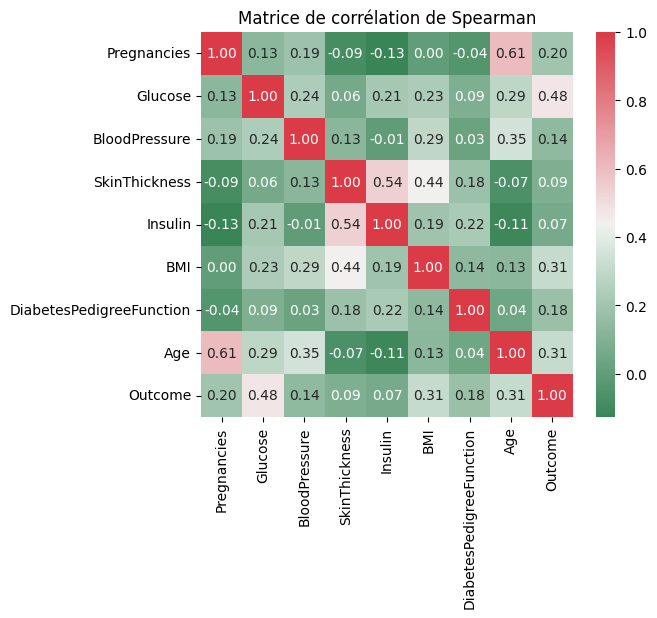

In [ ]:
cmap = sns.diverging_palette(500, 10, as_cmap=True)
plt.figure(figsize=(6, 5))
corr = df_raw[num_cols+["Outcome"]].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap=cmap, fmt=".2f")
plt.title("Matriz de correlación de Spearman")
plt.show()

Tenemos correlaciones muy altas entre la edad y los numeros de bebe y tambien entre glucose y la target. No quitermos estas variables pero tenemos que guardar en mente que puede haber multicolinealidad. No detectamos una correlacion tan alta entre el insulin y el glucose.

In [49]:
corr["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.475776
BMI                         0.309707
Age                         0.309040
Pregnancies                 0.198689
DiabetesPedigreeFunction    0.175353
BloodPressure               0.142921
SkinThickness               0.089728
Insulin                     0.066472
Name: Outcome, dtype: float64

Como hemos visto, antes glucose tiene mayor correlacion con el target, seguido de BMI.

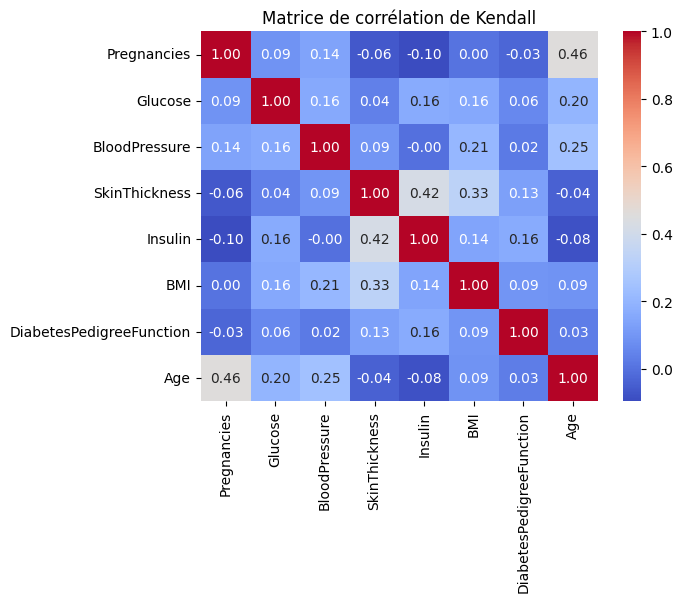

In [ ]:
kendall_results = pd.DataFrame(index=num_cols, columns=num_cols)
p_values = pd.DataFrame(index=num_cols, columns=num_cols)

for col1 in num_cols:
    for col2 in num_cols:
        tau, p_value = kendalltau(df_raw[col1], df_raw[col2])
        kendall_results.loc[col1, col2] = tau
        p_values.loc[col1, col2] = p_value

kendall_results = kendall_results.astype(float)
p_values = p_values.astype(float)
sns.heatmap(kendall_results, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de correlación de Kendall")
plt.show()


1.	Relaciones más destacadas:
-	SkinThickness–Insulin (0.42) y SkinThickness–BMI (0.33) siguen mostrando una correlación moderada, lo que refuerza la relación entre grasa corporal y resistencia a la insulina.
-	Age correlaciona de forma moderada con Pregnancies (0.46) y algo con BloodPressure (0.25), lo cual es lógico: a mayor edad, más embarazos y presión más alta.
2.	Glucose tiene relaciones suaves pero constantes con varias variables (0.16 aprox. con muchas), indicando su papel central en el perfil metabólico.
3.	Correlaciones cercanas a cero:
-	Relaciones como Insulin–BloodPressure (-0.00) o Glucose–SkinThickness (0.04) son prácticamente nulas, lo que sugiere independencia entre estas variables.

In [ ]:
X = add_constant(df_raw[num_cols])


vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


print(vif_data)


                    feature        VIF
0                     const  35.039974
1               Pregnancies   1.430872
2                   Glucose   1.298961
3             BloodPressure   1.181863
4             SkinThickness   1.507432
5                   Insulin   1.427536
6                       BMI   1.297450
7  DiabetesPedigreeFunction   1.067090
8                       Age   1.588368


No tenemos problema de multicolinealidad (correlación moderada)

## T-Test

In [52]:
def t_student(gp1, gp2):
    stat, p = ttest_ind(gp1, gp2)

    print(f"Statistique de test : {stat:.3f}")
    print(f"P-value : {p:.3f}")

    
    if p < 0.05:
        print("Diferencia significativa entre los grupos.")
    else:
        print("Ninguna diferencia significativa entre los grupos.")
        return None

group1_age = df_raw[df_raw['Outcome'] == 0]['Age']
group2_age = df_raw[df_raw['Outcome'] == 1]['Age']
t_student(group1_age, group2_age)



Statistique de test : -6.793
P-value : 0.000
Diferencia significativa entre los grupos.


## Informacion mutual

In [ ]:
df_raw['Outcome'] = df_raw['Outcome'].astype(int)
X = df_raw.drop(columns=["Outcome"])
y = df_raw["Outcome"]

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

mi_series_grouped = mi_series.groupby(lambda x: x.split('-')[0]).sum().reset_index()
mi_series_grouped.sort_values(by=0, ascending=False).reset_index(drop=True).rename(columns={'index': 'col_name', 0: 'importancia'}).style.background_gradient(cmap='coolwarm')


,col_name,importance
0,Glucose,0.114634
1,BMI,0.080061
2,Pregnancies,0.060985
3,Age,0.051395
4,DiabetesPedigreeFunction,0.014590
5,Insulin,0.011948
6,SkinThickness,0.004667
7,BloodPressure,0.000000


Se puede ver que la variable BloodPressure no aporta mucha información para entender la target.

# Hipotesis

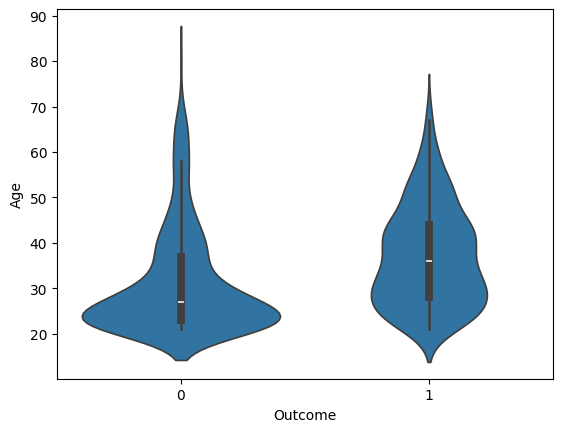

In [54]:
sns.violinplot(x='Outcome', y='Age', data=df_raw);

No podemos sacar muchas informaciones con la variable edad tal cual para nuestra hipotesis. Vamos a tranformarla en categoria.

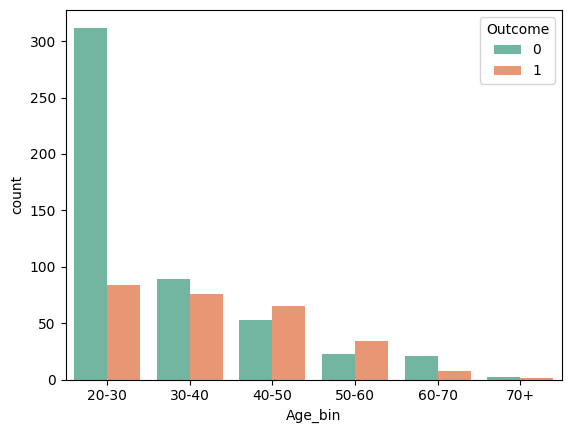

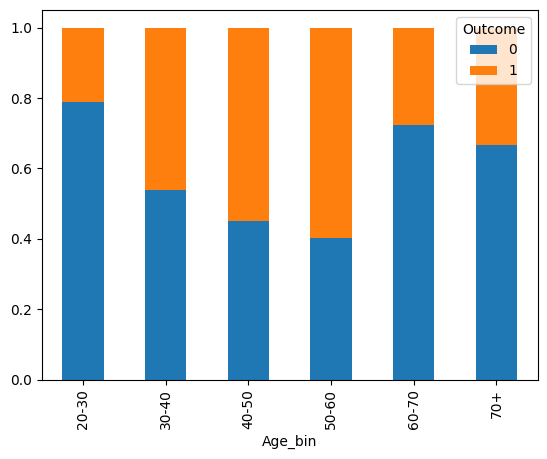

In [55]:
df_raw['Age_bin'] = pd.cut(df_raw['Age'], bins=[20, 30, 40, 50, 60, 70, np.inf], labels=['20-30', '30-40', '40-50', '50-60','60-70',"70+"],right=False)

sns.countplot(data=df_raw, x="Age_bin", hue='Outcome', palette="Set2")
plt.show()

pd.crosstab(df_raw['Age_bin'], df_raw['Outcome'], normalize='index').plot(kind='bar', stacked=True)
plt.show()

Las personas con más casos de diabetes en este gráfico están entre los 30 y los 60 años. Esto nos da más pistas sobre la relación entre la edad y el resultado del diagnóstico. A partir de los 60, parece que hay menos casos, pero eso podría deberse a que hay menos datos de personas mayores o a algún tipo de diferencia generacional. Podríamos dejarlo así si asumimos que el dataset está bien, o revisar si falta representatividad en esas edades.

# Final

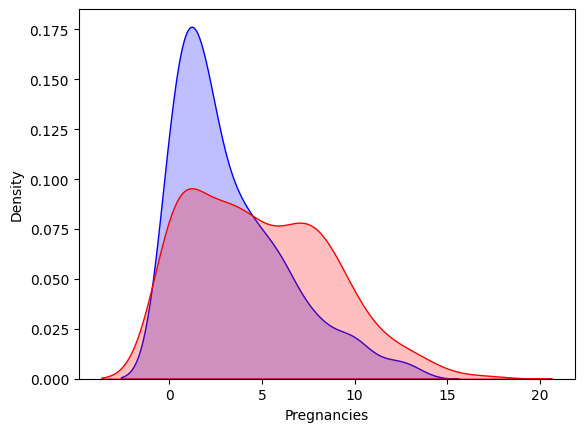

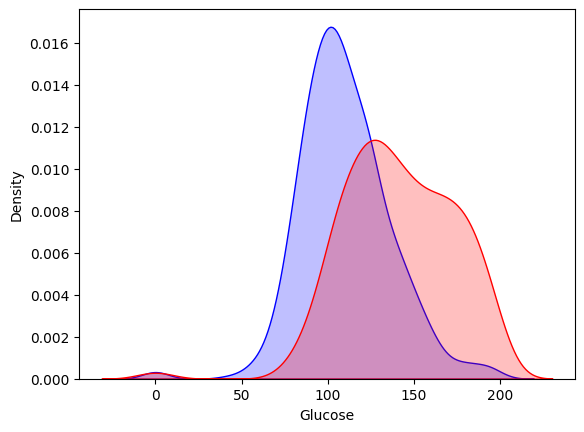

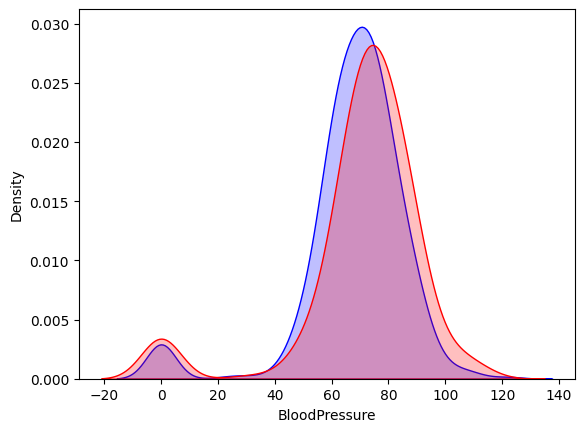

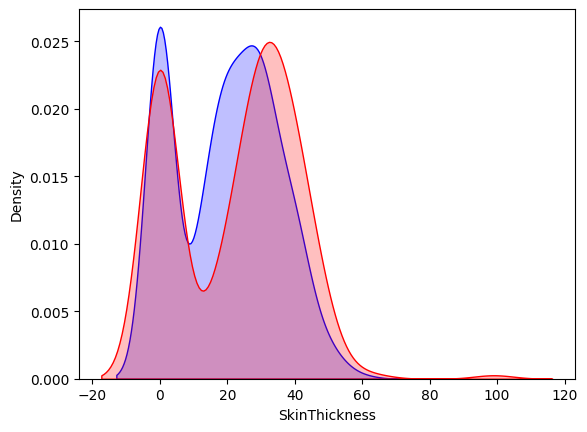

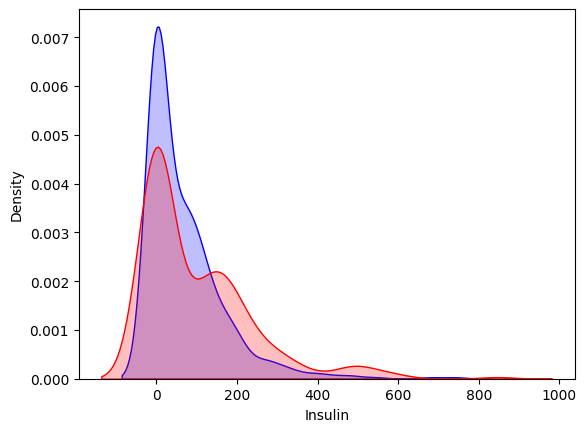

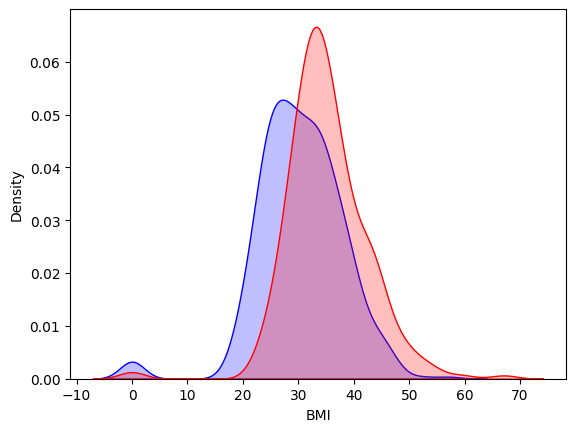

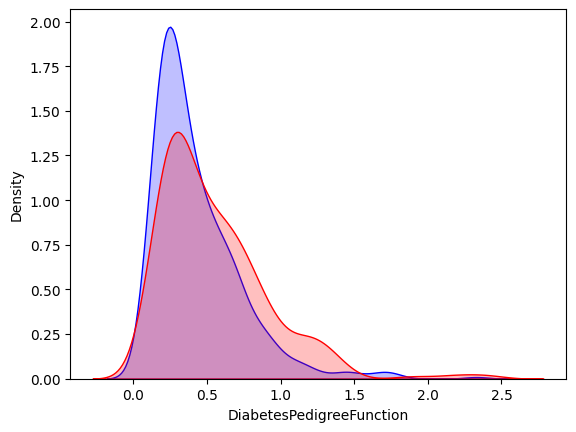

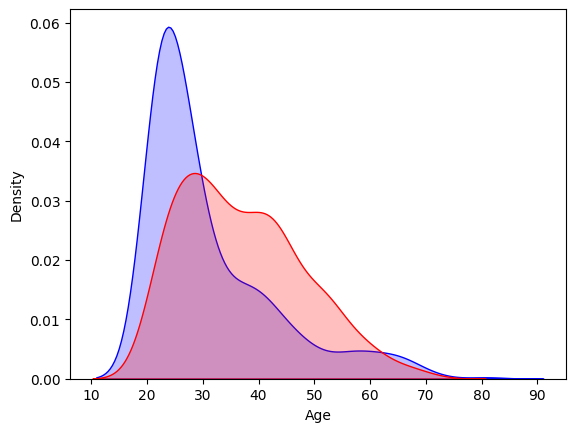

In [56]:
for column in num_cols:
    sns.kdeplot(data=df_raw[df_raw['Outcome'] == 0], x=column, label='No diabete', fill=True, color='blue')
    sns.kdeplot(data=df_raw[df_raw['Outcome'] == 1], x=column, label='diabete', fill=True, color='red')
    plt.show()

Estas gráficas de densidad comparan la distribución de cada variable entre personas con y sin diabetes. En cada gráfico, la curva azul representa a quienes no tienen diabetes y la roja a quienes sí la tienen. A partir de esto se pueden sacar varias conclusiones interesantes:
-	Glucosa: Es la variable con la diferencia más clara. Las personas con diabetes tienen niveles de glucosa  superiores. La mayoría de personas sin diabetes están entre 80 y 130, mientras que los casos positivos suelen estar por encima de 130.
-	BMI (Índice de Masa Corporal): También se nota una diferencia. Las personas con diabetes tienden a tener un número mayor, con una curva desplazada hacia la derecha.
-	Edad y Embarazos: Las personas con diabetes suelen ser mayores y haber tenido más embarazos. Aunque las curvas se alinean, la diferencia es visible: los casos positivos están más distribuidos hacia valores altos.
-	Insulina y SkinThickness: Hay más dispersión en los casos de diabetes. Aunque hay solapamiento, las curvas muestran que los diabéticos tienden a tener valores más elevados, especialmente en insulina.
-	BloodPressure y DiabetesPedigreeFunction: Las diferencias muy pequeñas. Las curvas están bastante superpuestas, lo que sugiere que por sí solas no son tan importantes, aunque podrían ser útiles combinadas con otras variables.

<Axes: xlabel='Age_bin', ylabel='count'>

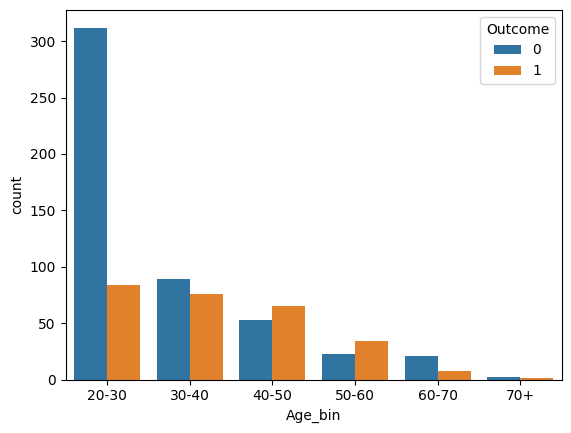

In [ ]:
#sns.countplot(data=df_raw, x="Age_bin", hue='Outcome')

# Conclusion

1.	Distribución del target (Outcome):
-	El dataset está desbalanceado: solo el 34.9% de las personas tiene diabetes, lo que puede influir en el siguiente modelo.
2.	Problemas en los datos:
-	Hay muchos valores  de cero no válidos en variables como Insulin, SkinThickness, BloodPressure y BMI, lo que indica datos faltantes mal introducidos.
-	Insulin y SkinThickness están muy sesgadas hacia la derecha y contienen muchos ceros, por lo que requieren imputación (se plantea usar la mediana o métodos como KNN o imputación iterativa).
-	Se detectaron varios outliers (Pregnancies, Age, Insulin, BMI), pero se decidió no eliminarlos directamente ya que pueden reflejar situaciones clínicas reales o serán tratados adelante.
3.	Estrategias de limpieza:
-	Se usa windsorización para algunas variables (basada en el rango intercuartílico).
-	Para valores extremos como insulina > 500, se decide imputar en lugar de eliminar.
-	Para ceros imposibles (como BMI = 0), se imputa con estadísticas del dataset.
4.	Análisis de hipótesis:
-	Se confirman algunas relaciones esperadas:
-	Personas con diabetes suelen tener glucosa y BMI más altos.
-	También tienden a ser más mayores y tener más embarazos.
-	Variables como BloodPressure o DiabetesPedigreeFunction no muestran diferencias tan marcadas entre personas con y sin diabetes.
5.	Observaciones adicionales:
-	La mayoría de la población en el dataset tiene sobrepeso, lo cual es coherente si el dataset se enfoca en una población de riesgo.
-	Algunas diferencias en las variables según el grupo podrían verse afectadas por la representatividad de ciertos rangos de edad (como en personas mayores de 60 años).